In [1]:
from MySQL_connection import df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sklearn


    ID             Cartridge    Type  Weight     BC    V0  V100  V200    E0  \
0    1   44 REMINGTON MAGNUM   Rifle     225  0.145  1870  1416  1106  1747   
1    2            357 MAGNUM   Rifle     140  0.169  1850  1458  1165  1064   
2    3            30 CARBINE   Rifle     110  0.178  2000  1601  1279   977   
3    4          35 REMINGTON   Rifle     200  0.192  2080  1697  1375  1921   
4    5      45-70 GOVERNMENT   Rifle     325  0.230  2050  1730  1451  3032   
5    6        450 BUSHMASTER   Rifle     250  0.210  2200  1835  1515  2686   
6    7            450 MARLIN   Rifle     325  0.230  2225  1887  1587  3572   
7    8      30-30 WINCHESTER   Rifle     150  0.193  2390  1974  1608  1902   
8    9         8X57MM MAUSER   Rifle     170  0.205  2360  1970  1624  2102   
9   10            444 MARLIN   Rifle     265  0.225  2325  1971  1654  3180   
10  11              458 LOTT   Rifle     500  0.295  2300  2029  1778  5872   
11  12     7.62X39MM RUSSIAN   Rifle     123  0.295 

### Let's create two dataFrames 
##### First for learning and secound for testing

In [2]:
#Creation of new df (we will use it for testing later)
#Drop the columns 'ID' 'BD100' and 'BD200' - they are useless here
test_df = df.drop(['ID', 'BD100', 'BD200'], axis=1)

#Now I create new df for learning. It contains 30 random notations from database of balistics
learning_df = pd.DataFrame(data={
                                 'Cartridge':pd.Series([], index=[],dtype=object),
                                 'Type':pd.Series([], index=[],dtype=object),
                                 'Weight':pd.Series([], index=[],dtype=object),
                                 'BC':pd.Series([], index=[],dtype=object),
                                 'V0':pd.Series([], index=[],dtype=object),
                                 'V100':pd.Series([], index=[],dtype=object),
                                 'V200':pd.Series([], index=[],dtype=object),
                                 'E0':pd.Series([], index=[],dtype=object),
                                 'E100':pd.Series([], index=[],dtype=object),
                                 'E200':pd.Series([], index=[],dtype=object),
                                })


#filling 'learning_df' with 30 random notes
for i in range(0, 30):
    
    #random index to choose a note
    j = random.randrange(0, 54-i)
    
    #extracting j'th note from test_df and inserting it into learning_df
    note = test_df.iloc[j]
    learning_df = learning_df.append(note, ignore_index=True)
    test_df = test_df.drop(test_df.index[j], axis=0)

#indexation of test_df was damaged. Let's reset it!
test_df = test_df.reset_index().drop(['index'], axis=1)


#### Let's see velocity distribution on different ditances:
(here we use only learning_df data)
### 0 feets:

mean velocty =  2675.7
std =  342.74833936567956


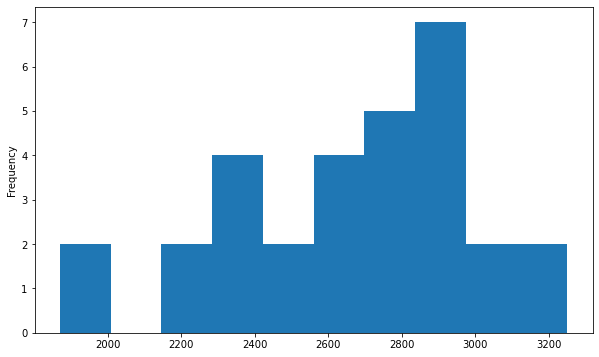

In [3]:
#Overview of 'V0' distribition 
plt.figure(figsize=(10,6))
learning_df['V0'].plot(kind='hist')

#'V0' mean and std
mean_V0 = learning_df['V0'].mean()
std_V0 = learning_df['V0'].std()

print('mean velocty = ', mean_V0)
print('std = ', std_V0)

### 100 feets :

mean velocty =  2404.633333333333
std =  393.19473839161503


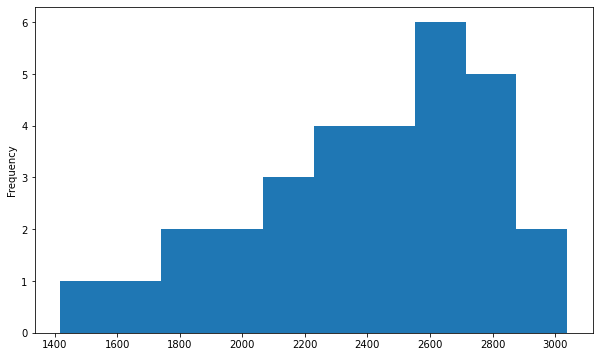

In [4]:
#Overview of 'V100' distribition 
plt.figure(figsize=(10,6))
learning_df['V100'].plot(kind='hist')

#'V100' mean and std
mean_V100 = learning_df['V100'].mean()
std_V100 = learning_df['V100'].std()

print('mean velocty = ', mean_V100)
print('std = ', std_V100)

### 200 feets :

mean velocty =  2157.3333333333335
std =  427.37969336276444


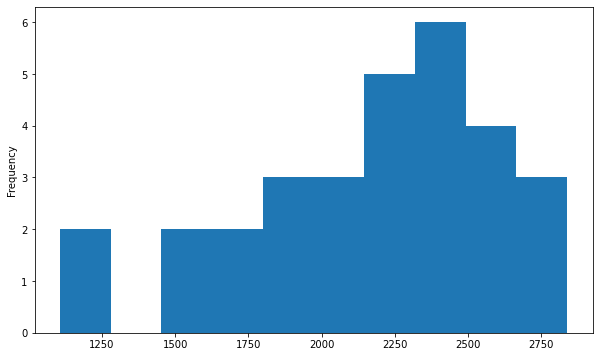

In [5]:
#Overview of 'V200' distribition 
plt.figure(figsize=(10,6))
learning_df['V200'].plot(kind='hist')

#'V200' mean and std
mean_V200 = learning_df['V200'].mean()
std_V200 = learning_df['V200'].std()

print('mean velocty = ', mean_V200)
print('std = ', std_V200)

##### Let's see also mean velocity changes due to ditance and 
##### what is the weight of bullets distribution

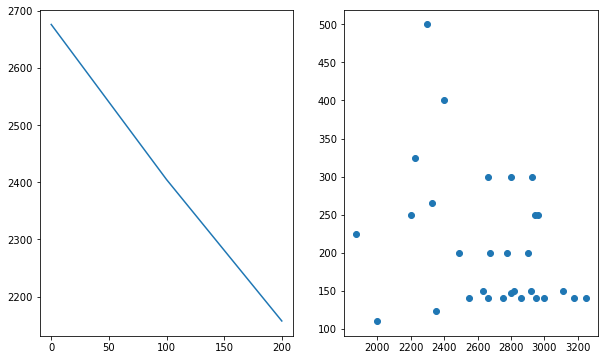

In [6]:
#I create figure for plots
figure = plt.figure(figsize=(10,6))

#creating plots and locating them
ax1 = figure.add_subplot(1, 2, 1) 
ax2 = figure.add_subplot(1,2,2) 

#filling the plots
mean_velocity = [mean_V0, mean_V100, mean_V200]
distance = [0, 100, 200]

mass = learning_df['Weight']
V0 = learning_df['V0']

ax1.plot(distance, mean_velocity)
ax2.scatter(V0, mass)


Left axe shows that on this distance we can suppose that velocity changes linearly. Right axe show that there are no correlation between mass and velocity. So we can make hipothesis about if we know mass, balistic coeficient and muzzle velocity we can predict how bullet's velocity changes.

# Learning

I'm gonna use linear regression model and learn it with 'learning_df'